# ZTF24aahgqwk in NGC 3443

## Light Curve Notebook

This notebook begins with the 36 stacked images produced by our [Calibration Notebook](https://brianhill.github.io/supernova-observation/analyses/ZTF24aahgqwk/ZTF24aahgqwk-calibration.pdf), and produces a light curve, consisting of 18 Sloan r' and 18 Sloan g' data points.

See [a least squares notebook](https://brianhill.github.io/supernova-observation/analyses/ZTF24aahgqwk/related_analyses/least_squares.pdf) for
background for the method used below.

In [1]:
import os
import numpy as np
from scipy.optimize import least_squares
from astropy import units as u
from astropy.nddata import CCDData
from astropy.io import fits
from ccdproc import ImageFileCollection
import astroalign as aa
import matplotlib.pyplot as plt
%matplotlib inline
from math import log10, floor, sqrt, log, exp, pi

# THIS COMMENT IS THE LONGEST A LINE CAN BE AND STILL RENDER COMPLETELY WHEN PRINTING IN LANDSCAPE MODE.
# THIS COMMENT IS 72 CHARACTERS WITHOUT COUNTING THE NEWLINE AT THE END.

# This notebook needs to be able to find the stacked images.

home_directory = os.path.expanduser('~')
supernova_project_directory = os.path.join(home_directory, 'Projects', 'supernova-observation')
stacked_directory = os.path.join(supernova_project_directory, 'analyses', 'ZTF24aahgqwk', 'stacked')

# The 36 images are in the stacked directory. There were 18 observation sessions with 2 filters each.

# filters

filters = ['r', 'g']
filter_full_names = ["Sloan r'", "Sloan g'"]

# observation dates (UTC)

# GENERALLY SPEAKING, VARIABLES IN ALL_CAPS SHOULD BE EXAMINED AND POSSIBLY ALTERED IF APPLYING THIS
# NOTEBOOK TO A DIFFERENT SUPERNOVA.

OBSERVATION_DATES = [
    '2024-03-20',
    '2024-03-21',
    '2024-03-23',
    '2024-03-27',
    '2024-04-02',
    '2024-04-03',
    '2024-04-04',
    '2024-04-06',
    '2024-04-10',
    '2024-04-11',
    '2024-04-13',
    '2024-04-17',
    '2024-04-21',
    '2024-04-22',
    '2024-04-23',
    '2024-04-29',
    '2024-04-30',
    '2024-05-02'
]

IMAGE_WIDTH = 1381
IMAGE_HEIGHT = 939 # TODO: WAS THIS EXPECTED? THE CALIBRATION NOTEBOOK HAS 940.

# We will need to specify rectangles surrounding the target and the reference stars.

# use named tuples to improve readability

from collections import namedtuple

Point = namedtuple('Point', 'x y')
Extent = namedtuple('Extent', 'width height')
Rectangle = namedtuple('Rectangle', 'center extent')

# Various utilities

def confirm_fits_header(image, dimensions, filter):
    header = image.header
    assert header['NAXIS1'] == dimensions[0]
    assert header['NAXIS2'] == dimensions[1]
    if filter:
        assert header['FILTER'].rstrip() == filter

def file_for_date_and_filter(date, filter):
    return os.path.join(stacked_directory, date + '-' + filter + '_stacked.fit')

def stacked_image_for_date_and_filter(date, filter):
    file = file_for_date_and_filter(date, filter)
    image = CCDData.read(file, unit=u.adu)
    confirm_fits_header(image, (IMAGE_WIDTH, IMAGE_HEIGHT), filter)
    return image

# Log stretch utility

def log_stretch_transform(black_point, saturation_range):
    
    log_saturation_range = log10(saturation_range)
    
    def fn(pixel_value):
        pixel_value -= black_point
        if pixel_value <= 1.0:
            return 0
        else:
            log_pixel_value = log10(pixel_value)
            if log_pixel_value >= log_saturation_range:
                return 255;
            else:
                return floor(256 * log_pixel_value / log_saturation_range)
        
    return fn


## Specify the Regions of Interest for the Target and Reference Stars

In [2]:
# Guarantee the extent widths and heights are odd so the loops do not have to handle even and odd cases.
EXTENT_HALF_WIDTH = 10
EXTENT_WIDTH = 2 * EXTENT_HALF_WIDTH + 1
EXTENT_HEIGHT = EXTENT_WIDTH
EXTENT = Extent(EXTENT_WIDTH, EXTENT_HEIGHT)

CENTERS = [
    Point(708, 443), # target
    Point(177, 109), # reference star at far upper left
#     Point(112, 368), # reference star at far left
#     Point(585, 426), # reference star just left of center
#     Point(982, 591), # reference star right of center
#     Point(1271, 280), # reference star at far right
]


## Display a Representative Image


Set OBSGEO-Y to -4483194.922 from OBSGEO-[LBH].
Set OBSGEO-Z to  3851220.317 from OBSGEO-[LBH]'. [astropy.wcs.wcs]


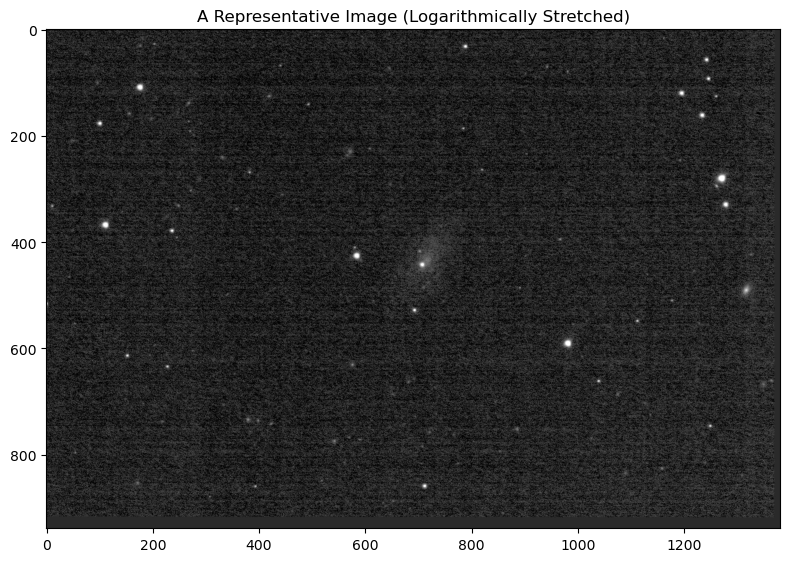

In [3]:
first_image = stacked_image_for_date_and_filter('2024-04-03', 'r')

# Log stretch

stretch_function = log_stretch_transform(8, 50)
stretch_transform = np.vectorize(stretch_function)

stretched_image = stretch_transform(first_image.data)

# Display the image

fig, axes = plt.subplots(1, 1, figsize=(8, 8))

axes.imshow(stretched_image, cmap='gray')
axes.set_title("A Representative Image (Logarithmically Stretched)")

plt.tight_layout()
plt.show()


### Display a Subframe of the Image

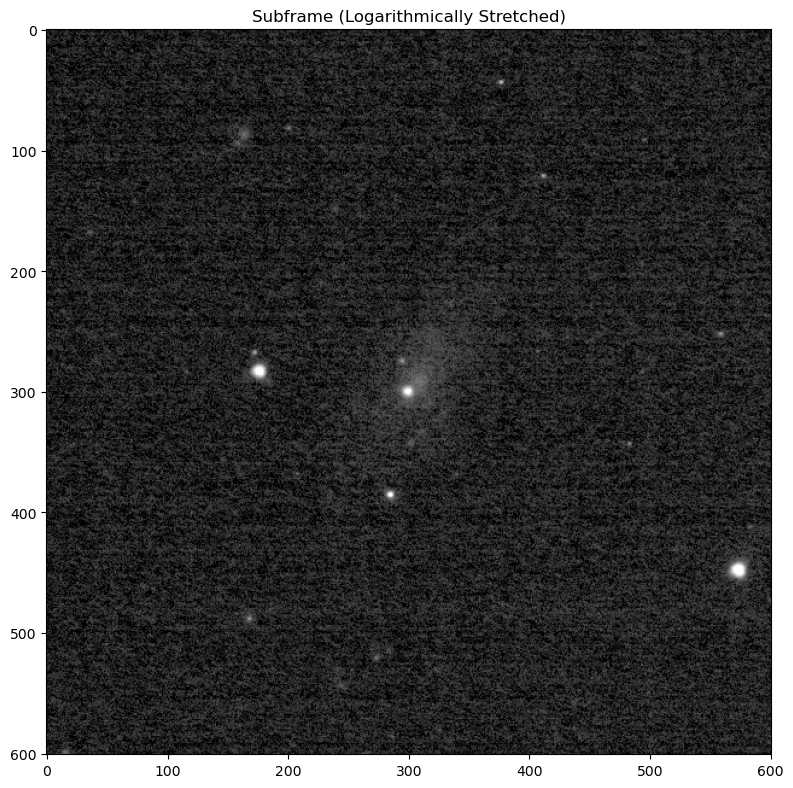

In [4]:
DISPLAY_WHICH_CENTER = 0  # This determines what the subframe will be centered on

display_extent_half = 300
display_extent_width = 2 * display_extent_half + 1
display_extent_height = display_extent_width
display_extent = Extent(display_extent_width, display_extent_height)

display_center = CENTERS[DISPLAY_WHICH_CENTER]
display_left = display_center.x - display_extent_half
display_right = display_left + display_extent_width
display_top = display_center.y - display_extent_half
display_bottom = display_top + display_extent_height

subframe = stretched_image[display_top:display_bottom, display_left:display_right]

# Display the representative subtracted dark

fig, axes = plt.subplots(1, 1, figsize=(8, 8))

axes.imshow(subframe, cmap='gray')
axes.set_title("Subframe (Logarithmically Stretched)")

plt.tight_layout()
plt.show()


## Code for Least Squares Fit

In [5]:
def sigma_squared_for_fwhm(fwhm):
    return fwhm**2 / (8 * log(2))

def make_gaussian(fwhm):
    sigma_squared = sigma_squared_for_fwhm(fwhm)
    normalization = 1 / (2 * pi * sigma_squared)
    def gaussian(x, y):
        return normalization * exp(-(x**2 + y**2) / (2 * sigma_squared))
    return gaussian

# The following mess of integers defines the parameter positions in the parameter vector
PINDEX_TARGET_BACKGROUND = 0  # NB: THE TARGET BACKGROUND IS IN ADDITION TO THE GENERAL_BACKGROUND
PINDEX_GENERAL_BACKGROUND = 1
PINDEX_FWHM = 2
POFFSET_BASE = 3  # the number of indices above -- will grow if we further model target background
POFFSET_MULTIPLE = 3  # the number of indices below -- not expected to change
POFFSETINDEX_FLUX = 0
POFFSETINDEX_CENTER_RELATIVE_X = 1  # NB: THIS IS RELATIVE TO THE CENTER OF THE EXTENT
POFFSETINDEX_CENTER_RELATIVE_Y = 2  # NB: THIS IS RELATIVE TO THE CENTER OF THE EXTENT

def roi_model_for_parameters(extent, k, centers, parameters):
    fwhm = parameters[PINDEX_FWHM]
    target_background = parameters[PINDEX_TARGET_BACKGROUND]
    general_background = parameters[PINDEX_GENERAL_BACKGROUND]
    base_index_k = POFFSET_BASE + k * POFFSET_MULTIPLE
    flux = parameters[base_index_k + POFFSETINDEX_FLUX]
    center_relative_x = parameters[base_index_k + POFFSETINDEX_CENTER_RELATIVE_X]
    center_relative_y = parameters[base_index_k + POFFSETINDEX_CENTER_RELATIVE_Y]
    background = target_background + general_background if k == 0 else general_background
    model_roi_data = np.full((extent.height, extent.width), background) # height before width
    gaussian = make_gaussian(fwhm)
    for j in range(extent.height):
        for i in range(extent.width):
            model_roi_data[j, i] += flux * gaussian(
                i - extent.width // 2 - center_relative_x,
                j - extent.height // 2 - center_relative_y
            )
    return model_roi_data

def view_extent_of_data(image_data, center, extent):
    left = center.x - extent.width // 2
    right = left + extent.width
    top = center.y - extent.height // 2
    bottom = top + extent.height
    view = image_data[top:bottom, left:right]
    return view

def make_image_data(width, height, centers, extent, parameters):
    general_background = parameters[PINDEX_GENERAL_BACKGROUND]
    image_data = np.full((height, width), general_background) # height before width in the array shape
    for k in range(len(centers)):
        model_roi_data = roi_model_for_parameters(extent, k, centers, parameters)
        view = view_extent_of_data(image_data, centers[k], extent)
        for j in range(extent.height):
            for i in range(extent.width):
                view[j, i] = model_roi_data[j, i]
    return image_data

def roi_residuals(image_data, k, centers, extent, parameters):
    roi_view = view_extent_of_data(image_data, centers[k], extent)
    roi_model = roi_model_for_parameters(extent, k, centers, parameters)
    return roi_view - roi_model

def make_residuals_function(image_data, centers, extent):
    def residuals_function(parameters):
        all_roi_residuals = [
            roi_residuals(image_data, k, centers, extent, parameters)
            for k, center in enumerate(centers)
        ]
        return np.concatenate(all_roi_residuals).ravel()
    
    return residuals_function


## Testing

We test the least squares fitting code above with generated data.

### Generate the Data

In [6]:
# The following are in all caps and prefixed TEST to avoid collisions with the real data.

TEST_DATA_WIDTH = 300
TEST_DATA_HEIGHT = 200

TEST_EXTENT_HALF_WIDTH = 10
TEST_EXTENT_WIDTH = 2 * TEST_EXTENT_HALF_WIDTH + 1
TEST_EXTENT_HEIGHT = TEST_EXTENT_WIDTH
TEST_EXTENT = Extent(TEST_EXTENT_WIDTH, TEST_EXTENT_HEIGHT)

TEST_CENTERS = [
    Point(20, 40), # test target
    Point(50, 150), # test reference star
]

TEST_CENTER_OFFSETS = [
    Point(2, 6), # test target
    Point(-2, -5), # test reference star
]

TEST_CENTERS_WITH_OFFSETS = [
    Point(TEST_CENTERS[i].x + TEST_CENTER_OFFSETS[i].x, TEST_CENTERS[i].y + TEST_CENTER_OFFSETS[i].y)
    for i in range(len(TEST_CENTERS))
]

TEST_TARGET_BACKGROUND = 5.0
TEST_GENERAL_BACKGROUND = 3.0

TEST_FWHM = 3.0

TEST_FLUXES = [
    250.0,
    1000.0
]

TEST_PARAMETERS = [
    TEST_TARGET_BACKGROUND,
    TEST_GENERAL_BACKGROUND,
    TEST_FWHM
]

for k in range(len(TEST_CENTERS)):
    TEST_PARAMETERS.append(TEST_FLUXES[k])
    TEST_PARAMETERS.append(TEST_CENTER_OFFSETS[k].x)
    TEST_PARAMETERS.append(TEST_CENTER_OFFSETS[k].y)


TEST_IMAGE_DATA = make_image_data(
    TEST_DATA_WIDTH, TEST_DATA_HEIGHT,
    TEST_CENTERS,
    TEST_EXTENT,
    TEST_PARAMETERS
)


### Display the Test Image

Near, but exactly at (20, 40), we should see a target with flux 250.0.
Around it the total backround is 5.0 + 3.0.

Near, but not exactly at (50, 150), we should see a reference star with flux 1000.0.
Around it the background is 3.0.

The FWHM should appear to be about 9.0.

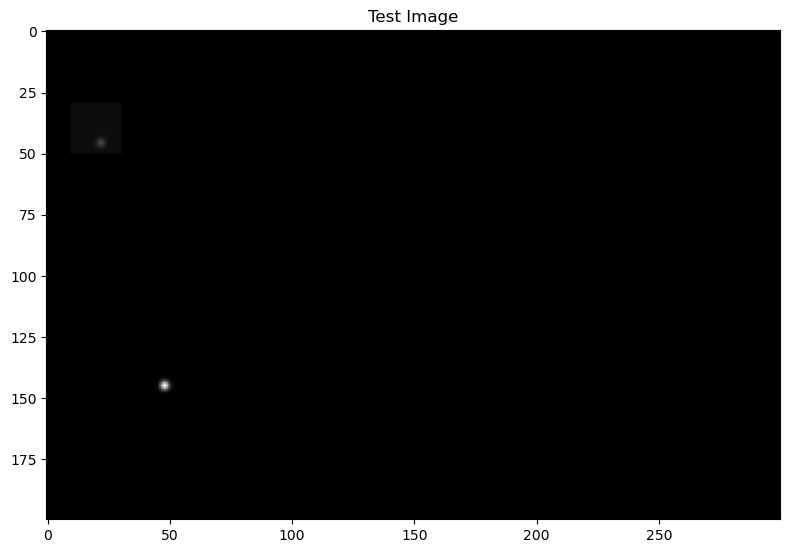

In [7]:
# Display the representative subtracted dark

fig, axes = plt.subplots(1, 1, figsize=(8, 8))

axes.imshow(TEST_IMAGE_DATA, cmap='gray')
axes.set_title("Test Image")

plt.tight_layout()
plt.show()


### Fit the Test Image

The routine was doing perfectly with the test data, but I have introduced a bug!!

TODO: We could put Poisson noise into the test data and see how robust the routine is.

In [8]:
# The following are in all caps and prefixed TEST to avoid collisions with the real fit.

TEST_INITIAL_GUESS_FOR_TARGET_BACKGROUND = 0.0
TEST_INITIAL_GUESS_FOR_GENERAL_BACKGROUND = 0.0
TEST_INITIAL_GUESS_FOR_FWHM = 5.0

TEST_INITIAL_PARAMETER_VECTOR = [
    TEST_INITIAL_GUESS_FOR_TARGET_BACKGROUND,
    TEST_INITIAL_GUESS_FOR_GENERAL_BACKGROUND,
    TEST_INITIAL_GUESS_FOR_FWHM
]

for _ in range(len(TEST_CENTERS)):
    TEST_INITIAL_PARAMETER_VECTOR.append(10.0)  # Initial guess for flux
    TEST_INITIAL_PARAMETER_VECTOR.append(0.0)   # Initial guess for center_relative_x
    TEST_INITIAL_PARAMETER_VECTOR.append(0.0)   # Initial guess for center_relative_y
    
TEST_RESIDUALS_FUNCTION = make_residuals_function(TEST_IMAGE_DATA, TEST_CENTERS, TEST_EXTENT)

TEST_RESULT = least_squares(TEST_RESIDUALS_FUNCTION, np.array(TEST_INITIAL_PARAMETER_VECTOR))


In [9]:
TEST_RESULT.x

# TEST_IMAGE_DATA[140:161, 40:61]

array([ 3.47723897,  5.05013055, -0.47056999, 14.71414629,  1.68727063,
        5.0001742 , 24.05178497, -2.00212708, -5.0017037 ])

## Fit the Real Data

This is turning out to be a completely unexpected and incorrect fit still.

As an example, result.x\[PINDEX_FWHM\] has the nonsensical value -0.3679.

In [10]:
initial_guess_for_target_background = 0.0
initial_guess_for_general_background = 0.0
initial_guess_for_fwhm = 5.0

initial_parameter_vector = [
    initial_guess_for_target_background,
    initial_guess_for_general_background,
    initial_guess_for_fwhm
]

for _ in range(len(CENTERS)):
    initial_parameter_vector.append(100.0)  # Initial guess for flux
    initial_parameter_vector.append(0.0)   # Initial guess for center_x
    initial_parameter_vector.append(0.0)   # Initial guess for center_y

residuals_function = make_residuals_function(first_image, CENTERS, EXTENT)

result = least_squares(residuals_function, np.array(initial_parameter_vector))

result.x

array([-8.98814612e+00,  2.76082718e+01, -3.67927662e-01,  1.20848391e+02,
        9.70725558e+00,  2.43020926e+01,  1.25483690e+02,  4.17399547e-03,
        3.01484339e-03])

## Display the Fit

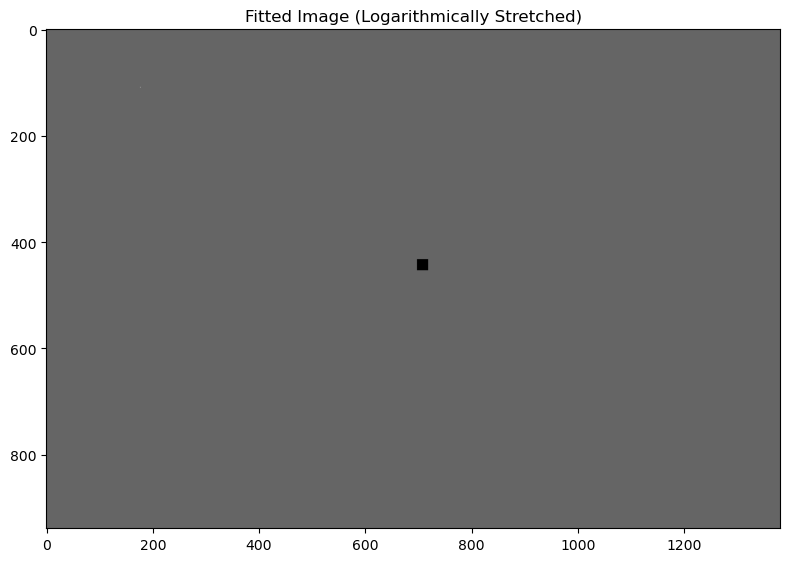

In [11]:
fitted_image_data = make_image_data(IMAGE_WIDTH, IMAGE_HEIGHT, CENTERS, EXTENT, result.x)
    
# THIS COMMENT IS THE LONGEST A LINE CAN BE AND STILL RENDER COMPLETELY WHEN PRINTING IN LANDSCAPE MODE.

stretched_fitted_image = stretch_transform(fitted_image_data)

# Display the image

fig, axes = plt.subplots(1, 1, figsize=(8, 8))

axes.imshow(stretched_fitted_image, cmap='gray')
axes.set_title("Fitted Image (Logarithmically Stretched)")

plt.tight_layout()
plt.show()


In [12]:
result.x[PINDEX_FWHM]

-0.36792766163270535